# Test and debug Kalman filter v0

---

## Equations verified by the simulator

$$
\begin{align}
(1+a) m \frac{d^2z_f}{dt^2} = 
- mg
+ mg \frac{\rho_w}{\rho_f}
- m \frac{c_1}{2L} \Big |\frac{dz_f}{dt} - w \Big | \Big ( \frac{dz_f}{dt} - w \Big )
\end{align}
$$

## Equations employed by the Kalman filter

The Kalman state vector is:

$$
\begin{align*}
\underline{x} &= 
\left(\begin{array}{c} 
x_0\\
x_1\\
x_2\\
x_3
\end{array}\right)
=
\left(\begin{array}{c} 
-dz_f/dt\\
-z_f\\
\gamma_e \\
V_e \\
\end{array}\right)
\end{align*}
$$

Variables estimated by the Kalman filter are therefore the depth temporal rate of evolution ($x_0$, in m/s), depth ($x_1$, in m), equivalent compressibility ($\gamma_e$, in m$^2$) and the equivalent volume ($x_3$,  in m$^3$).

The Kalman filter dynamical equation is:

$$
\begin{align}
d\underline{x}/dt &= 
\left(\begin{array}{c} 
dx_0/dt\\
dx_1/dt\\
dx_2/dt\\
dx_3/dt
\end{array}\right)
=
\left(\begin{array}{c} 
-d^2z_f/dt^2\\
-dz_f/dt\\
0\\
0
\end{array}\right)
= 
\left(\begin{array}{c} 
-A (x_3 - x_2 x_1 +v) - B |x_0| x_0 \\
x_0\\
0 \\
0
\end{array}\right), \label{eq:dxdt}
\end{align}
$$

, where several parameters have been introduced: $A = g\rho/2m$ and $B = c_1/4L$.

which dimensionally is equivalent to:

\begin{align}
(1+a) m \frac{d^2z_f}{dt^2} = 
g \rho (V_e + \gamma_e z + v)
- m \frac{c_1}{2L} \Big |\frac{dz_f}{dt} \Big | \Big ( \frac{dz_f}{dt} \Big )
\end{align}

where $V_e= V_0 [\delta\rho_w(\overline{z}) - \overline{z} \partial_z \rho_w ]/\rho$, $\gamma_e = V_0 \partial_z \rho_w /\rho + \gamma_V$, and, $\overline{z}$ is the averaged vertical level the float is moving around.



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from copy import deepcopy

import cognac.float as fl

---

## quick note on feedback

We choose the following relaxation function:

$$
\begin{align}
y = x_0 - \nu \arctan{\frac{\overline{x}_1-x_1}{\delta}},
\label{eq:y_0}
\end{align}
$$

where $\overline{x}_1$ is the target depth, $\nu_{reg} = \nu \pi/2$ is the typical vertical velocity the float should move at, and $\delta$ is a length scale that defines the zone of influence around the target depth. 

We are searching the command $u$ such that $y$ is the solution of:

$$
\begin{align}
\ddot y + \lambda_1 \dot y + \lambda_2 y = 0. \label{eq:y}
\end{align}
$$

For an exponential law of the type $y\sim e^{-r t}$ to be solution of the latter equations, we may choose: $\lambda_1=2r$, $\lambda_2=r^2$. 
For $r=0.1$~s$^{-1}$: $\lambda_1=0.2$~s$^{-1}$, $\lambda_2=0.01$~s$^{-2}$.

This choice of $y$ is such that when $t\xrightarrow{}\infty$: $x_0=\nu \arctan{\frac{\overline{x}_1-x_1}{\delta}}$.
This means that $x_0\xrightarrow{}0$ when $|x_1-\overline{x}_1|<\delta$. 
The float vertical velocity should also never be greater that $\pm \nu \times \pi/2$.


WOA water profile at lon=6, lat=40


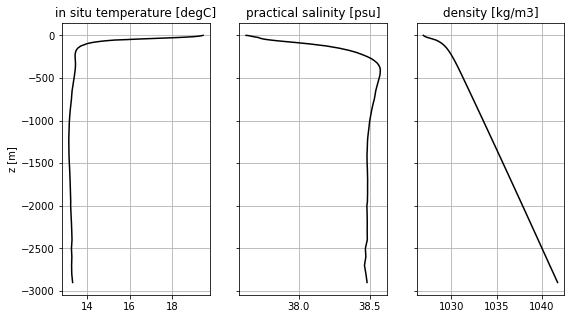

In [2]:
# select a water profile
#w = fl.waterp(lon=-50.,lat=40.) # Gulf Stream
w = fl.waterp(lon=6.,lat=40.) # Mediterranean sea
print(w)

--- 
## Instantiate the float object

In [3]:
# Init now active control of the vertical position

#
z=np.arange(-500.,0.,1.)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

#
f = fl.autonomous_float(model='Ifremer')
f.init_piston()
print(f)

# adjust mass to be at equilibrium at 0m and substract 5g
iz = np.argmin(np.abs(z+0))
f.adjust_m(p[iz],temp[iz],rho_w[iz], offset=-5)

# compute bounds on motions
fmax, fmin, afmax, wmax = f.compute_bounds(w,-500.)

Piston max volume set from max displacement
Float parameters: 
  L     = 0.83 m      - float length
  r     = 0.07 m      - float radius
  m     = 11.63 kg     - float mass
  V     = 1.27e+04 cm^3   - float volume
  rho_cte = m/V = 9.13e+08 kg.cm^3   - float baseline density
  gamma = 3.78e-06 /dbar  - mechanical compressibility
  gamma x V = 4.82e-02 cm^3/dbar  - normalized compressibility
  alpha = 6.98e-05 /degC  - thermal compressibility
  alpha x V = 8.89e-01 cm^3/degC  - normalized thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
  a = 1.00e+00  (no dimension)  - float added mass
  c0 = 0.00e+00  (no dimension)  - float drag parameter 0
  c1 = 1.00e+00  (no dimension)  - float drag parameter 1
Piston parameters and state: 
  r     = 0.97 cm        - piston radius
  d     = 0.00 cm        - present piston displacement
  vol   = 26.88 cm^3      - present volume addition
  d_increment  = 8.57e-02 mm        - smallest variation of translation motion for the p

Piston reset for equilibrium : vol=2.2e+01 cm^3  
z equilibrium = -1.0m


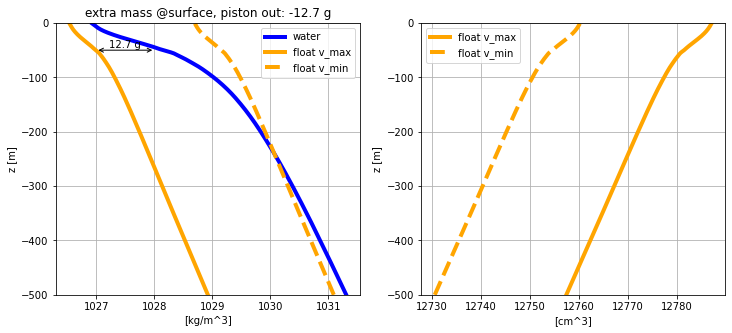

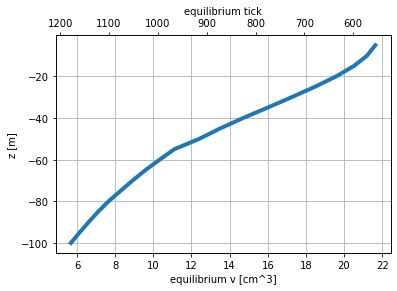

In [4]:
# adjust piston to be at equilibrium -1m
z0 = -1.
iz = np.argmin(np.abs(z-z0))
vstart = f.set_piston4equilibrium(p[iz],temp[iz],rho_w[iz])
print('z equilibrium = %.1fm' %(f.z4equilibrium(w) ) )

# show densities
fig, ax = plt.subplots(1, 2, figsize=(12,5))
fl.plot_float_density(z, f, w, ax=ax[0])
fl.plot_float_volume(z, f, w, ax=ax[1])
_ = fl.plot_equilibrium_volume(f, w)

In [5]:
# physical parameters used for kalman parameters

delta_rho = 2 # [kg/m3] change of water density over the depth of interest 
L_rho = 100 # [m] characteristic length scale for water density changes
V_e_rho = f.V*delta_rho/f.rho_cte # back of the envelope estimate for V_e
acceleration_rho = 0.5*fl.g*delta_rho/f.rho_cte

print('delta_rho = {:.2e} kg/m^3'.format(delta_rho))
print('L_rho = {:.2e} m'.format(L_rho))
print('V_e_rho = {:.2e} m'.format(V_e_rho))
print('acceleration_rho = {:.2e} m/s2'.format(acceleration_rho))
print('acceleration 0 to 10cm in 10s = {:.2e} m/s2'.format(0.1/10))

delta_rho = 2.00e+00 kg/m^3
L_rho = 1.00e+02 m
V_e_rho = 2.47e-05 m
acceleration_rho = 9.52e-03 m/s2
acceleration 0 to 10cm in 10s = 1.00e-02 m/s2


### equivalent volume and compressibilities

Back of the envelope estimate of V_e: 2.5e+01 cm^3


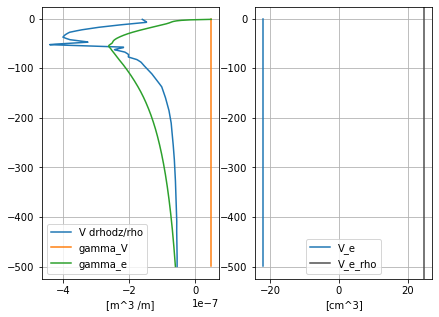

In [6]:
zm = (z[1:]+z[:-1])*.5

## linearization around local z (z bar)
V_e = f.V*( (rho_w[:-1]+rho_w[1:])*.5 - f.rho_cte 
           - zm*np.diff(rho_w)/np.diff(z)
          )/f.rho_cte
# V_e should be 0 at balasting point (surface, vol_max):
_dV_surf =  (f.compute_force(0., 0., w, 1., v=f.piston.vol_max))/(9.81*f.rho_cte) \
           - f.piston.vol_max
V_e = V_e - V_e[-1] + _dV_surf
    
gamma_V = f.V*f.gamma
gamma_rho = f.V*np.diff(rho_w)/f.rho_cte/np.diff(z)
gamma_e = gamma_rho + gamma_V

## linearization from surface down 
if True:
    V_e = f.V* (rho_w[:-1]+rho_w[1:])*.5/f.rho_cte
    V_e = V_e - V_e[-1] + _dV_surf
    gamma_e =  (V_e - _dV_surf)/zm + gamma_V
    V_e = V_e*0. + _dV_surf

V_e100 = interp1d(zm, V_e, kind='linear')(-25)
gamma_e100 = interp1d(zm, gamma_e, kind='linear')(-25)

plt.figure(figsize=(7,5))
ax=plt.subplot(121)
ax.plot(gamma_rho, zm, label='V drhodz/rho')
ax.plot(gamma_V+0.*zm, zm, label='gamma_V')
ax.plot(gamma_e, zm, label='gamma_e')
ax.grid()
ax.legend(loc=3)
ax.set_xlabel('[m^3 /m]')

ax=plt.subplot(122)
ax.plot(V_e*1e6, zm, label='V_e')
ax.axvline(x=V_e_rho*1e6, color='0.3',label='V_e_rho')
ax.grid()
ax.legend()
ax.set_xlabel('[cm^3]')

print('Back of the envelope estimate of V_e: %.1e cm^3' %(V_e_rho*1e6))

---

### set up desired trajectory

In [7]:
# we start by constructing a trajectory that can be followed by the float
target_velocity = 0.1
z_target = fl.descent(3600, -20., wmax=10., zstart=z0)

Tsim = 1000.
f0 = deepcopy(f)

---

### Kalman filter with exact dynamical system

The true dynamical equation is reset to that used by the Kalman and regulation:

\begin{align}
(1+a) m \frac{d^2z_f}{dt^2} = 
g \rho (V_e + \gamma_e z + v)
- m \frac{c_1}{2L} \Big |\frac{dz_f}{dt} \Big | \Big ( \frac{dz_f}{dt} \Big )
\end{align}

In [8]:
# use PID for control to decouple Kalman filtering from control
u = f.piston.u_max # m^3/s
delta = 20. # m
tau = 15. # time scale

_c = {'mode': 'pid', 'dt': 1.,
      'Kp': u/delta, 'Ki': u/delta/tau*0., 'Kd': u/delta*tau*0., 
      'dz_nochattering': 0.}

In [9]:
V_e_cst = -f.piston.vol_max/2.
gamma_e_cst = -5*f.gammaV

def _compute_force(z, w, waterp, Lv, v=None, sum=False):
    g = 9.81
    f_b = g * f.rho_cte * (V_e_cst + gamma_e_cst * z + v)
    f_d = - f.m * f.c1/2/Lv * np.abs(w) * w
    if sum:
        return f_b+f_d
    else:
        return f_b+f_d, f_b, f_d
    
f.compute_force = _compute_force

Kalman filter: 
  dt     = 0.50 s     - filter time step
  x_hat   = [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00] - kalman state 
  sqrt(diag(gamma)): [2.00e-01 1.00e-01 4.82e-08 1.34e-05]
  sqrt(gamma_alpha) / dt: [9.52e-05 4.76e-05 4.82e-11 1.34e-08]
  sqrt(gamma_beta): [1.00e-01]
Start time stepping for 16 min ...
... time stepping done


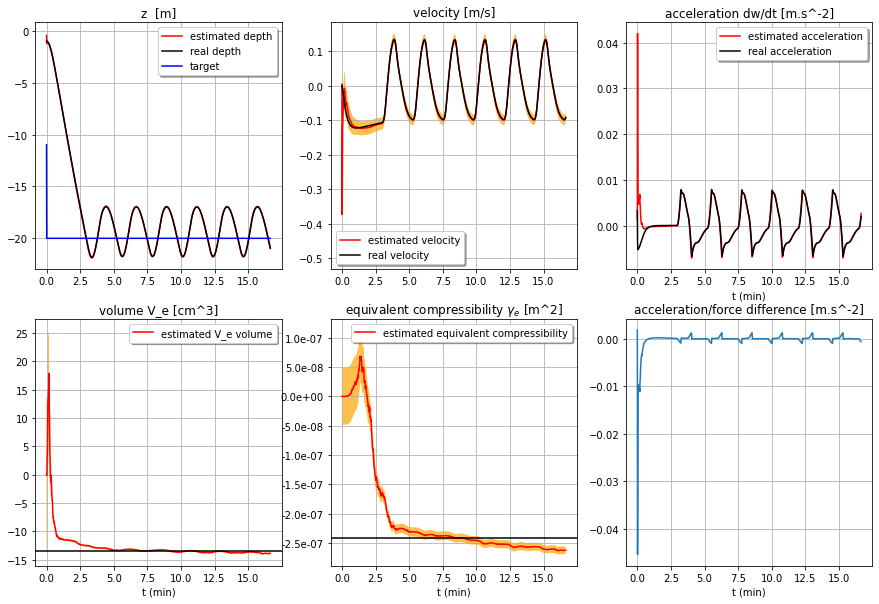

In [10]:
long_time_scale = 1e3 # time scale used to scale V_e and gamma_e time rate of change

# general kalman filter parameters
_k = {'version': 'v0', 'dt':.5, 'depth_error': 1e-1}
# initial state vector
#_k.update({'x_init': [0.,0.,-f.gammaV,0.]})
_k.update({'x_init': [0., 0., 0., 0.]})
# initial state covariance:
_k.update({'gamma_init':np.array([_k['depth_error']/_k['dt'],
                                  _k['depth_error'],
                                  f.gammaV,
                                  V_e_cst,
                                 ])**2
          })
# dynamics covariance:
_k.update({'gamma_alpha_scaled': np.array([acceleration_rho /1e2,
                                           acceleration_rho*_k['dt'] /1e2,
                                           f.gammaV/long_time_scale,
                                           V_e_cst/long_time_scale,
                                          ])**2
          })
# observation error covariance:
_k.update({'gamma_beta': np.diag([_k['depth_error']**2])})

f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=vstart,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)
fl.plot_kalman_v0(f.log, f, V_e = V_e_cst, gamma_e = gamma_e_cst, z_target=z_target)

### turn off gamma_e

Kalman filter: 
  dt     = 0.50 s     - filter time step
  x_hat   = [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00] - kalman state 
  sqrt(diag(gamma)): [2.00e-01 1.00e-01 4.82e-14 1.34e-05]
  sqrt(gamma_alpha) / dt: [9.52e-05 4.76e-05 4.82e-17 1.34e-08]
  sqrt(gamma_beta): [1.00e-01]
Start time stepping for 16 min ...
... time stepping done


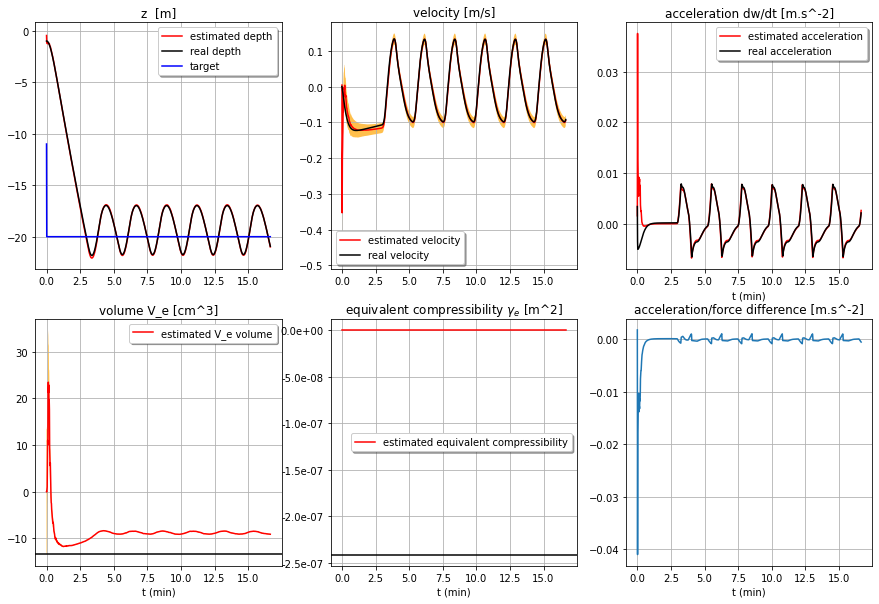

In [11]:
scale = 1e-6 # parameter use to turn off role of equivalent compressibility

_k.update({'gamma_init':np.array([_k['depth_error']/_k['dt'],
                                  _k['depth_error'],
                                  f.gammaV*scale,
                                  V_e_cst,
                                 ])**2
          })
_k.update({'gamma_alpha_scaled': np.array([acceleration_rho /1e2,
                                           acceleration_rho*_k['dt'] /1e2,
                                           f.gammaV/long_time_scale*scale,
                                           V_e_cst/long_time_scale,
                                          ])**2
          })

f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=vstart,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)
fl.plot_kalman_v0(f.log, f, V_e = V_e_cst, gamma_e = gamma_e_cst, z_target=z_target)

The offset on V_e is approximately consistent with what is expected from compressibility:

In [12]:
_z = -20.
print('volume offset due to compressibility at {}m depth: {:.2e} cm^3'.format(-_z, _z*gamma_e_cst*1e6))

volume offset due to compressibility at 20.0m depth: 4.82e+00 cm^3


---

### Kalman filter with real physics

In [13]:
f = deepcopy(f0)

Kalman filter: 
  dt     = 0.50 s     - filter time step
  x_hat   = [0.00e+00, 0.00e+00, -9.63e-08, 0.00e+00] - kalman state 
  sqrt(diag(gamma)): [2.00e-01 1.00e-01 4.82e-08 2.47e-05]
  sqrt(gamma_alpha) / dt: [9.52e-05 4.76e-05 2.47e-09 2.47e-07]
  sqrt(gamma_beta): [1.00e-01]
Start time stepping for 16 min ...
... time stepping done


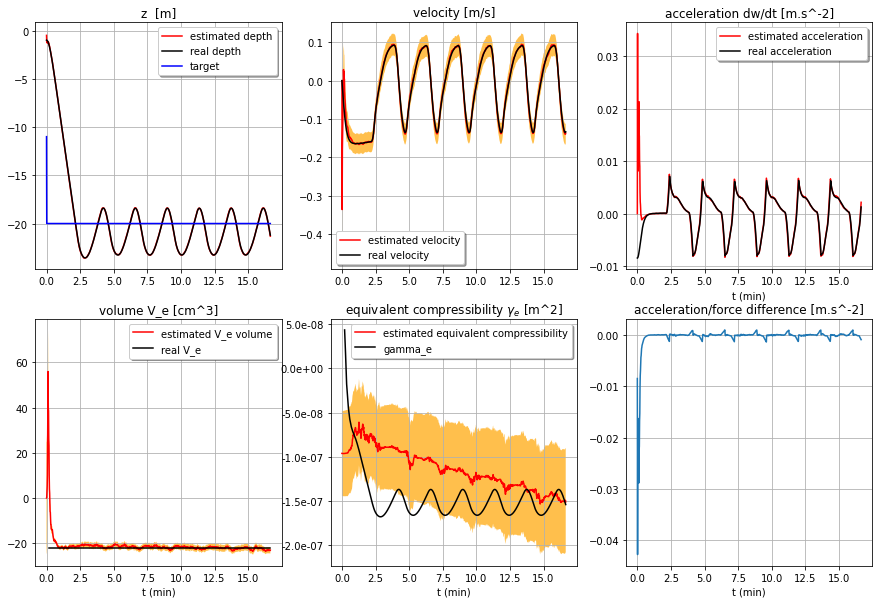

In [14]:
_k = {'version': 'v0', 'dt':.5, 'depth_error': 1e-1}

# initial state vector
_k.update({'x_init': [0., 0., -2*f.gammaV, 0.],
          'gamma_init':np.array([_k['depth_error']/_k['dt'],
                                 _k['depth_error'],
                                 f.gammaV,
                                 f.V*delta_rho/f.rho_cte,
                                 ])**2,
          'gamma_alpha_scaled': np.array([acceleration_rho /1e2,
                                          acceleration_rho*_k['dt'] /1e2,
                                          target_velocity*V_e_rho/L_rho**2 *1e1,
                                          target_velocity*V_e_rho/L_rho *1e1,
                                          ])**2})
# observation error covariance:
_k.update({'gamma_beta': np.diag([_k['depth_error']**2])})

f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

V_e_z = interp1d(zm, V_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
gamma_e_z = interp1d(zm, gamma_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
fl.plot_kalman_v0(f.log, f, V_e = V_e_z, gamma_e = gamma_e_z, z_target=z_target)

---

### Kalman filter with feedback regulation


Old comments:

Decreasing `tau` (5s, we used 15s initially) leads to an improved match up with the target trajectory.
A value of 1 second leads to spurious oscillations when we want the float to stay at a constant depth though.

In [15]:
_k = {'version': 'v0', 'dt':.5, 'depth_error': 1e-1}

# initial state vector
_k.update({'x_init': [0., 0., -2*f.gammaV, 0.],
          'gamma_init':np.array([_k['depth_error']/_k['dt'],
                                 _k['depth_error'],
                                 f.gammaV,
                                 f.V*delta_rho/f.rho_cte,
                                 ])**2,
          'gamma_alpha_scaled': np.array([acceleration_rho /1e2,
                                          acceleration_rho*_k['dt'] /1e2,
                                          target_velocity*V_e_rho/L_rho**2 *1e1,
                                          target_velocity*V_e_rho/L_rho *1e1,
                                          ])**2})
# observation error covariance:
_k.update({'gamma_beta': np.diag([_k['depth_error']**2])})

Kalman filter: 
  dt     = 0.50 s     - filter time step
  x_hat   = [0.00e+00, 0.00e+00, -9.63e-08, 0.00e+00] - kalman state 
  sqrt(diag(gamma)): [2.00e-01 1.00e-01 4.82e-08 2.47e-05]
  sqrt(gamma_alpha) / dt: [9.52e-05 4.76e-05 2.47e-09 2.47e-07]
  sqrt(gamma_beta): [1.00e-01]
Start time stepping for 16 min ...
... time stepping done


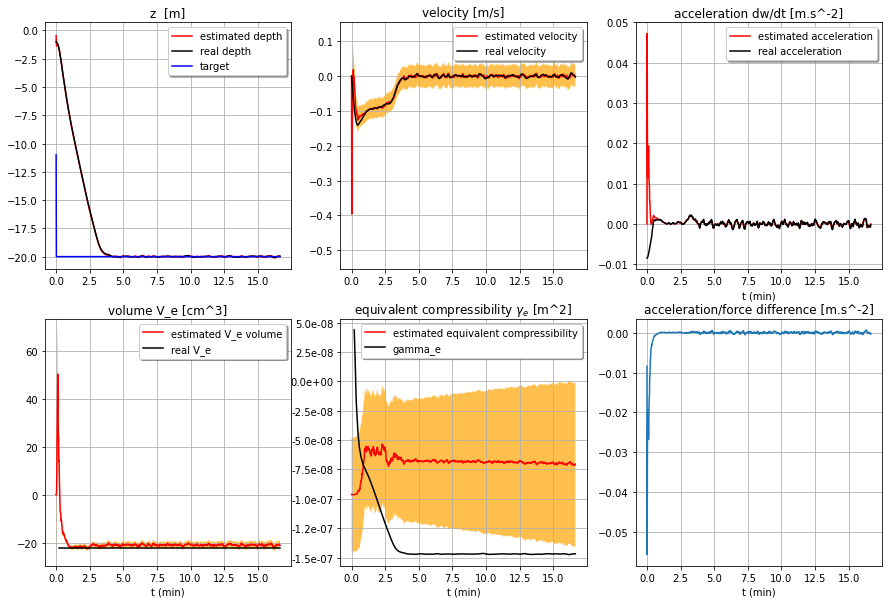

In [16]:
_c = {'mode': 'kalman_feedback2', 'dt': 1., 'dz_nochattering': 0., # dt=5,
      'nu': target_velocity*2./np.pi, 'tau': 5., 'delta': 1.,
      'continuous': False
     }

f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

V_e_z = interp1d(zm, V_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
gamma_e_z = interp1d(zm, gamma_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
fl.plot_kalman_v0(f.log, f, V_e = V_e_z, gamma_e = gamma_e_z, z_target=z_target)

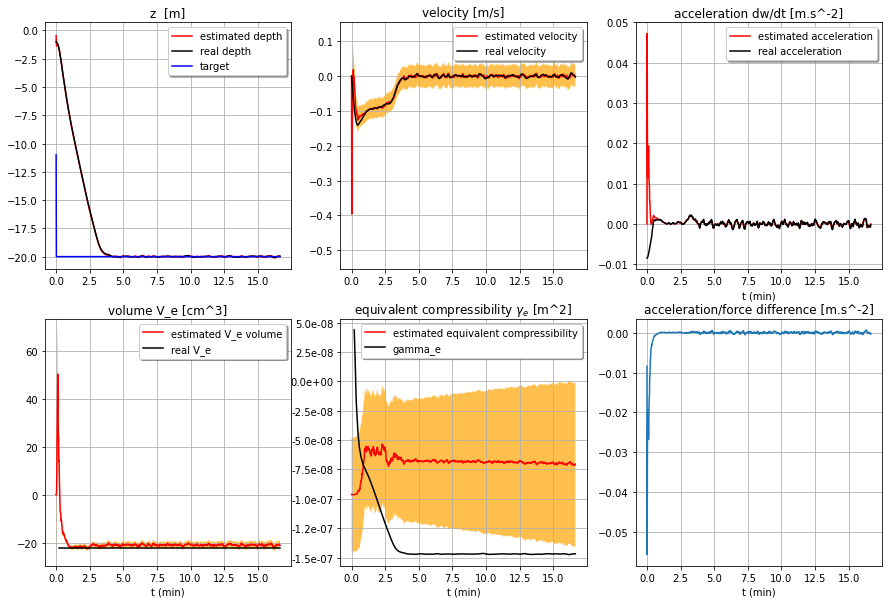

In [17]:
fl.plot_kalman_v0(f.log, f, V_e = V_e_z, gamma_e = gamma_e_z, z_target=z_target)

Extrapolated energy conssumption: 8.0e-03 Wh/day = 0.2 Wh/30day


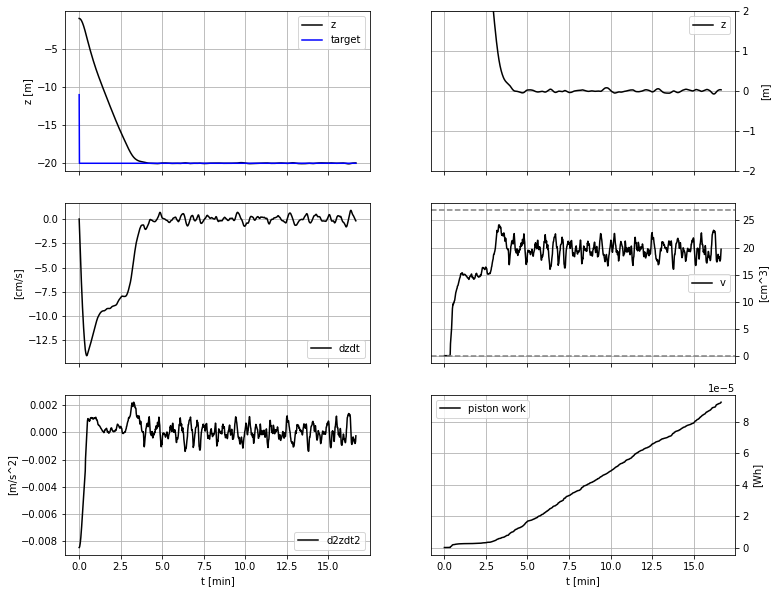

In [18]:
f.plot_logs(z_target=z_target)

In [21]:
f.log['dynamics'].plot_bk(gridded=False)

Loading BokehJS ...

---

### now increase time steps

!!! Need update !!!

In [20]:
scale = 2.

_k = {'dt':0.5*scale, 'depth_error': 1e-2}

_k.update({'gamma_e0': -2*f.gammaV, 'V_e0': 0.,
           'gamma':np.array([_k['depth_error']/_k['dt'],
                             _k['depth_error'],
                             f.gammaV,
                             f.V*delta_rho/f.rho_cte,
                            ])**2,
           'gamma_alpha_scaled': np.array([acceleration_rho,
                                           acceleration_rho*_k['dt'],
                                           target_velocity*V_e_rho/L_rho**2,
                                           target_velocity*V_e_rho/L_rho,
                                           ])**2 *1e0})

_c = {'mode': 'kalman_feedback2', 'dt': 5.*scale, 'dz_nochattering': 0.,
      'nu': 2*target_velocity*2./np.pi, 'tau': 10.*scale, 'delta': 1.,
      'continuous': False,
     }

f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

V_e_z = interp1d(zm, V_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
gamma_e_z = interp1d(zm, gamma_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)

fl.plot_kalman(f.log, f, V_e = V_e_z, gamma_e = gamma_e_z, z_target=z_target)

AssertionError: Kalman filter parameters should include: m, a, rho_cte, x_init, gamma_init

In [ ]:
scale = 5.

_k = {'dt':0.5*scale, 'depth_error': 1e-2}

_k.update({'gamma_e0': -2*f.gammaV, 'V_e0': 0.,
           'gamma':np.array([_k['depth_error']/_k['dt'],
                             _k['depth_error'],
                             f.gammaV,
                             f.V*delta_rho/f.rho_cte,
                            ])**2,
           'gamma_alpha_scaled': np.array([acceleration_rho,
                                           acceleration_rho*_k['dt'],
                                           target_velocity*V_e_rho/L_rho**2,
                                           target_velocity*V_e_rho/L_rho,
                                           ])**2 *1e0})

_c = {'mode': 'kalman_feedback2', 'dt': 5.*scale, 'dz_nochattering': 0.,
      'nu': 2*target_velocity*2./np.pi, 'tau': 10.*scale, 'delta': 1.,
      'continuous': False,
     }

f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

V_e_z = interp1d(zm, V_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
gamma_e_z = interp1d(zm, gamma_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)

fl.plot_kalman(f.log, f, V_e = V_e_z, gamma_e = gamma_e_z, z_target=z_target)

In [ ]:
print(f.kalman.A_coeff, f.kalman.B_coeff)